<a href="https://colab.research.google.com/github/gggggeun/My_study/blob/main/%EC%9C%84%EB%A1%9C%EC%B1%97%EB%B4%87.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 한국어 챗봇 
- Transformer model
- https://github.com/songys/Chatbot_data
- 따뜻한 위로를 해주는 챗봇

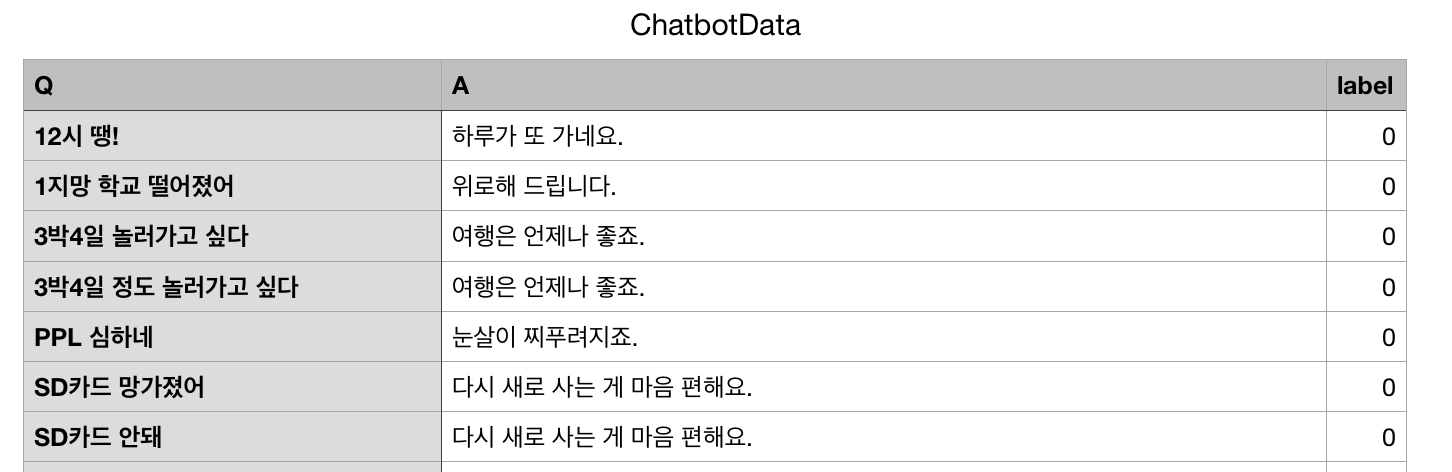

## 0. Transformer

이 자료는 위키독스 '딥 러닝을 이용한 자연어 처리 입문'의 트랜스포머 튜토리얼로 작성되었습니다.  
2021년 10월 8일에 정상 동작을 확인하였습니다.  

챗봇의 성능이 아쉽다면 모델의 크기를 조정해보세요.

링크 :  
https://wikidocs.net/31379  
https://wikidocs.net/89786

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
tf.__version__

'2.6.0'

In [3]:
# 최종 버전
class PositionalEncoding(tf.keras.layers.Layer):
  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스(2i)에는 사인 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])

    # 배열의 홀수 인덱스(2i+1)에는 코사인 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    angle_rads = np.zeros(angle_rads.shape)
    angle_rads[:, 0::2] = sines
    angle_rads[:, 1::2] = cosines
    pos_encoding = tf.constant(angle_rads)
    pos_encoding = pos_encoding[tf.newaxis, ...]

    print(pos_encoding.shape)
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

(1, 50, 128)


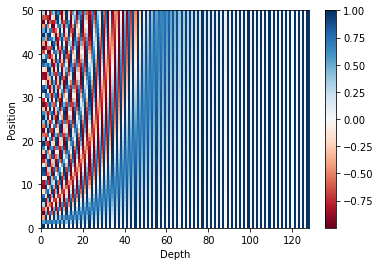

In [4]:
sample_pos_encoding = PositionalEncoding(50, 128)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 128))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [5]:
def scaled_dot_product_attention(query, key, value, mask):
  # query 크기 : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
  # key 크기 : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
  # value 크기 : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
  # padding_mask : (batch_size, 1, 1, key의 문장 길이)

  # Q와 K의 곱. 어텐션 스코어 행렬.
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 스케일링
  # dk의 루트값으로 나눠준다.
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 마스킹. 어텐션 스코어 행렬의 마스킹 할 위치에 매우 작은 음수값을 넣는다.
  # 매우 작은 값이므로 소프트맥스 함수를 지나면 행렬의 해당 위치의 값은 0이 된다.
  if mask is not None:
    logits += (mask * -1e9)

  # 소프트맥스 함수는 마지막 차원인 key의 문장 길이 방향으로 수행된다.
  # attention weight : (batch_size, num_heads, query의 문장 길이, key의 문장 길이)
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # output : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
  output = tf.matmul(attention_weights, value)

  return output, attention_weights

In [6]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    # d_model을 num_heads로 나눈 값.
    # 논문 기준 : 64
    self.depth = d_model // self.num_heads

    # WQ, WK, WV에 해당하는 밀집층 정의
    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    # WO에 해당하는 밀집층 정의
    self.dense = tf.keras.layers.Dense(units=d_model)

  # num_heads 개수만큼 q, k, v를 split하는 함수
  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # 1. WQ, WK, WV에 해당하는 밀집층 지나기
    # q : (batch_size, query의 문장 길이, d_model)
    # k : (batch_size, key의 문장 길이, d_model)
    # v : (batch_size, value의 문장 길이, d_model)
    # 참고) 인코더(k, v)-디코더(q) 어텐션에서는 query 길이와 key, value의 길이는 다를 수 있다.
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 2. 헤드 나누기
    # q : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    # k : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
    # v : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 3. 스케일드 닷 프로덕트 어텐션. 앞서 구현한 함수 사용.
    # (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)
    # (batch_size, query의 문장 길이, num_heads, d_model/num_heads)
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 4. 헤드 연결(concatenate)하기
    # (batch_size, query의 문장 길이, d_model)
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 5. WO에 해당하는 밀집층 지나기
    # (batch_size, query의 문장 길이, d_model)
    outputs = self.dense(concat_attention)

    return outputs

In [7]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, key의 문장 길이)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [8]:
def encoder_layer(dff, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 인코더는 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 멀티-헤드 어텐션 (첫번째 서브층 / 셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
          'mask': padding_mask # 패딩 마스크 사용
      })

  # 드롭아웃 + 잔차 연결과 층 정규화
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 포지션 와이즈 피드 포워드 신경망 (두번째 서브층)
  outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 드롭아웃 + 잔차 연결과 층 정규화
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [9]:
# @@@@수정됨
def encoder(vocab_size, num_layers, dff,
            d_model, num_heads, dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 인코더는 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 포지셔널 인코딩 + 드롭아웃
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # 인코더를 num_layers개 쌓기
  for i in range(num_layers):
    outputs = encoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
        dropout=dropout, name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [10]:
# 디코더의 첫번째 서브층(sublayer)에서 미래 토큰을 Mask하는 함수
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x) # 패딩 마스크도 포함
  return tf.maximum(look_ahead_mask, padding_mask)

In [11]:
def decoder_layer(dff, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")

  # 디코더는 룩어헤드 마스크(첫번째 서브층)와 패딩 마스크(두번째 서브층) 둘 다 사용.
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 멀티-헤드 어텐션 (첫번째 서브층 / 마스크드 셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
          'mask': look_ahead_mask # 룩어헤드 마스크
      })

  # 잔차 연결과 층 정규화
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 멀티-헤드 어텐션 (두번째 서브층 / 디코더-인코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1, 'key': enc_outputs, 'value': enc_outputs, # Q != K = V
          'mask': padding_mask # 패딩 마스크
      })

  # 드롭아웃 + 잔차 연결과 층 정규화
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 포지션 와이즈 피드 포워드 신경망 (세번째 서브층)
  outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 드롭아웃 + 잔차 연결과 층 정규화
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [12]:
def decoder(vocab_size, num_layers, dff,
            d_model, num_heads, dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')

  # 디코더는 룩어헤드 마스크(첫번째 서브층)와 패딩 마스크(두번째 서브층) 둘 다 사용.
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 포지셔널 인코딩 + 드롭아웃
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # 디코더를 num_layers개 쌓기
  for i in range(num_layers):
    outputs = decoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
        dropout=dropout, name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [13]:
def transformer(vocab_size, num_layers, dff,
                d_model, num_heads, dropout,
                name="transformer"):

  # 인코더의 입력
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 디코더의 입력
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더의 패딩 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더의 룩어헤드 마스크(첫번째 서브층)
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask, output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 디코더의 패딩 마스크(두번째 서브층)
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더의 출력은 enc_outputs. 디코더로 전달된다.
  enc_outputs = encoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
      d_model=d_model, num_heads=num_heads, dropout=dropout,
  )(inputs=[inputs, enc_padding_mask]) # 인코더의 입력은 입력 문장과 패딩 마스크

  # 디코더의 출력은 dec_outputs. 출력층으로 전달된다.
  dec_outputs = decoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
      d_model=d_model, num_heads=num_heads, dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 다음 단어 예측을 위한 출력층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

(1, 9000, 128)
(1, 9000, 128)


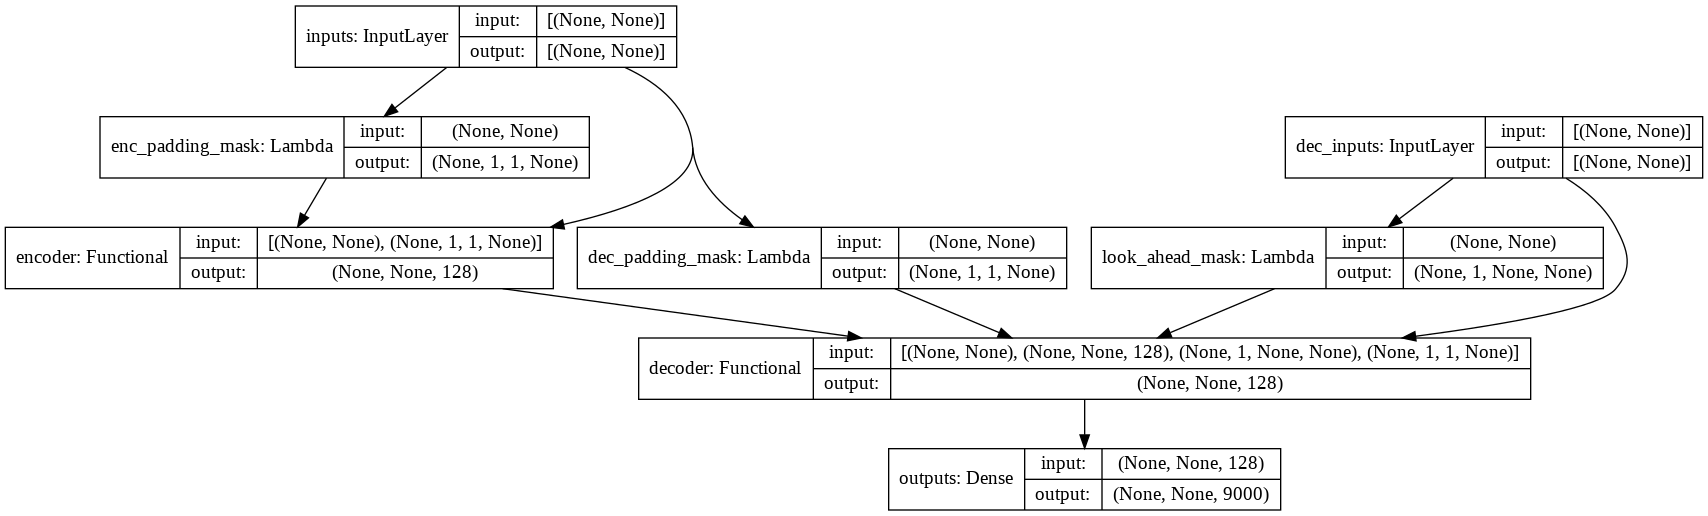

In [14]:
small_transformer = transformer(
    vocab_size = 9000,
    num_layers = 4,
    dff = 512,
    d_model = 128,
    num_heads = 4,
    dropout = 0.3,
    name="small_transformer")

tf.keras.utils.plot_model(
    small_transformer, to_file='small_transformer.png', show_shapes=True)

In [15]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

In [16]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)
    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

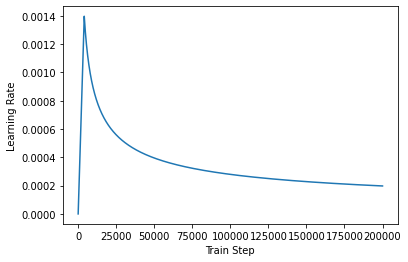

In [17]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request #URL을 열기 위한 확장 가능한 라이브러리
import time
import tensorflow_datasets as tfds # textencoder 토크나이저 사용을 위함
import tensorflow as tf

## 1. 데이터 로드하기

In [19]:
# URL로 표시된 네트워크 객체를 로컬 파일로 복사
urllib.request.urlretrieve("https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv"
, filename="ChatBotData.csv")
train_data = pd.read_csv('ChatBotData.csv')
train_data

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


In [20]:
print('챗봇 샘플 개수 :', len(train_data))

챗봇 샘플 개수 : 11823


In [21]:
# NULL 확인
print(train_data.isnull().sum())

Q        0
A        0
label    0
dtype: int64


In [22]:
# 구두점 분리(공백 추가) ex)땡! -> 땡 !

questions = []  #질문
for sentence in train_data['Q']:
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = sentence.strip()
  questions.append(sentence)  

answers = []  #대답
for sentence in train_data['A']:
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = sentence.strip()
  answers.append(sentence)  

In [23]:
# 구두점 분리 확인
print(questions[:5])
print(answers[:5])

['12시 땡 !', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다', '3박4일 정도 놀러가고 싶다', 'PPL 심하네']
['하루가 또 가네요 .', '위로해 드립니다 .', '여행은 언제나 좋죠 .', '여행은 언제나 좋죠 .', '눈살이 찌푸려지죠 .']


## 단어 집합(Vocabulary) 생성
- subword tokenizer 의 서브워드텍스트인코더 사용
- 서브워드 단위로 토큰을 분리하는 토크나이저로 학습 데이터로부터 학습해 서브워드로 구성된 단어집합(Vocabulary)을 생성
- https://www.tensorflow.org/datasets/api_docs/python/tfds/deprecated/text/SubwordTextEncoder

- BPE(Byte Pair Encoding) 알고리즘

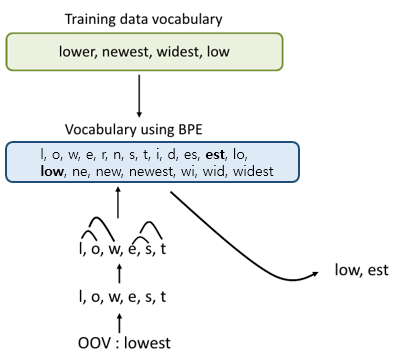

- SubwordTextEncoder 
  - 텐서플로우를 통해 사용할 수 있는 서브워드 토크나이저.
  - BPE와 유사한 알고리즘인 Wordpiece Model을 채택하였으며, 패키지를 통해 쉽게 단어들을 서브워드로 분리할 수 있다.
  - 글자 단위에서 점차 단어 집합을 만들어 낸다. 훈련 데이터의 모든 글자 또는 유니코드 단위로 단어집합을 만들고, 가장 많이 등장하는 유니그램을 하나의 유니그램으로 통합한다.
  - OOV나 희귀단어, 신조어 같은 문제를 완화시킬 수 있다. 하나의 단어를 서브워드로 분리해 단어를 인코딩 및 임베딩하겠다는 의도를 가진 전처리 작업이다.
  

In [24]:
# 어휘는 말뭉치에서 "훈련(train)"되고 모든 단어 조각은 어휘 파일(vocabulary file)에 저장된다.
# 말뭉치에서 어휘(vocabulary)를 생성하기 위해 build_frokm_corpus 사용 

tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, target_vocab_size=2**13)

In [25]:
# 시작토큰<SOS>, 종료토큰<EOS>을 Vocabulary에 포함해야하기 때문에 두 토큰에 정수 부여하기
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# 두 토큰을 고려해 단어 집합의 크기를 +2 
VOCAB_SIZE = tokenizer.vocab_size + 2

In [26]:
print('시작 토큰 번호 :', START_TOKEN)
print('종료 토큰 번호 :', END_TOKEN)
print('단어 집합의 크기 :', VOCAB_SIZE)

시작 토큰 번호 : [8178]
종료 토큰 번호 : [8179]
단어 집합의 크기 : 8180


패딩에 사용될 토큰(0번)부터 마지막 토큰(8,179번) 까지 총 8,180개이다.

## 3. 정수 인코딩과 패딩
- Vocabulary 생성 후 서브워드텍스트인코더의 토크나이저로 정수 인코딩 진행
- 토크나이저의 .encode()를 **사용**

In [27]:
# 임의의 샘플 1개로 시범 진행(샘플 20번 질문)

print('임의의 질문 샘플을 정수 인코딩 : {}'.format(tokenizer.encode(questions[20])))

임의의 질문 샘플을 정수 인코딩 : [5766, 611, 3509, 141, 685, 3747, 849]


In [28]:
# 반대로 정수 인코딩 된 결과는 다시 decode()를 사용해 기존의 텍스트 시퀀스로 복원 가능함.
# 20번 질문 인코딩 후 다시 디코딩해보기

sample_string = questions[20] # 입력문장을 변수에 저장

tokenized_string = tokenizer.encode(sample_string)
print('정수 인코딩 후의 문장: {}'.format(tokenized_string))

original_string = tokenizer.decode(tokenized_string)
print('기존 문장(디코딩): {}'.format(original_string))

정수 인코딩 후의 문장: [5766, 611, 3509, 141, 685, 3747, 849]
기존 문장(디코딩): 가스비 비싼데 감기 걸리겠어


- 정수인코딩의 개수와 기존 문장의 개수가 맞지 않는 것으로 보이는데, 이는 '가스비'나 '비싼데'라는 한 어절이 정수 인코딩 후에는 두 개 이상의 정수일 수 있기 때문이다. 
- 정수 인코딩 된 문장을 .decode() 하면 자동으로 서브워드들까지 다시 붙여서 기존 단어로 복원해준다.
- 각 정수가 어떤 서브워드로 맵핑되는지 출력할 수도 있다.

In [29]:
# mapping 확인하기

for ts in tokenized_string :
  print('{} ----> {}'.format(ts, tokenizer.decode([ts])))

5766 ----> 가스
611 ----> 비 
3509 ----> 비싼
141 ----> 데 
685 ----> 감기 
3747 ----> 걸리
849 ----> 겠어


- 패딩(Padding)
  - 자연어 처리를 하다보면 각 문장(또는 문서)은 서로 길이가 다를 수 있다. 그런데 기계는 길이가 전부 동일한 문서들에 대해서는 하나의 행렬로 보고, 한꺼번에 묶어서 처리할 수 있다. 패딩은 이러한 병렬 연산을 위해 여러 문장의 길이를 임의로 동일하게 맞춰주는 작업이다. 
  - 대표적으로 짧은 길이의 문장에 0을 넣어 총 길이를 맞춰주는 방식이 있으며, 0번 단어는 아무런 의미도 없는 단어이기 때문에 자연어 처리하는 과정에서 기계는 0번 단어를 무시하게 된다. 
  - 이와 같이 데이터에 특정 값을 채워서 데이터의 크기(shape)를 조정하는 것을 패딩이라고 한다. 숫자 0을 사용하고 있다면 제로패딩(zero padding)이라 한다.
  - keras의 pad_sequence는 기본적으로 문서 앞에 0을 채우는 방식이며, 뒤에 0을 채우고 싶다면 padding='post'를 주면된다.

In [30]:
# 전체 데이터에 대해 정수 인코딩과 패딩 진행하기

# 임의의 패딩 최대 길이를 40으로 정의
MAX_LENGTH = 40

# 토큰화 / 정수 인코딩 / 시작 토큰과 종료 토큰 추가 / 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []

  for (sentence1, sentence2) in zip(inputs, outputs):
    # encode(토큰화 + 정수 인코딩), 시작 토큰과 종료 토큰 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    tokenized_inputs.append(sentence1)
    tokenized_outputs.append(sentence2)

  # 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

  return tokenized_inputs, tokenized_outputs

In [31]:
questions, answers = tokenize_and_filter(questions, answers)

In [32]:
# 정수인코딩, 패딩 후의 데이터 크기 확인
print('질문 데이터 크기(shape) :', questions.shape)
print('답변 데이터 크기(shape) :', answers.shape)

질문 데이터 크기(shape) : (11823, 40)
답변 데이터 크기(shape) : (11823, 40)


질문과 답변 데이터의 모든 문장의 길이가 40으로 변환되었음을 확인하였다. 임의의 샘플을 출력해보자.

In [33]:
# 0번 샘플 임의로 출력
print(questions[0])
print(answers[0])

[8178 7915 4207 3060   41 8179    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
[8178 3844   74 7894    1 8179    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


길이 40을 맞추기 위해 뒤에 0이 패딩된 것을 확인할 수 있다.

## 4. 인코더와 디코더의 입력, 레이블 만들기
- tf.data.Dataset을 사용해 데이터를 배치 단위로 불러올 수 있다.
- tf.data.Dataset.from_tensor_slices : 주어진 텐서들을 첫번째 차원을 따라 슬라이스해 새로운 데이터셋을 만든다. 모든 입력 텐서는 첫 번째 차원과 같은 크기를 가져야한다.
- cache() : 데이터셋을 캐시, 즉 메모리 또는 파일에 보관한다. 따라서 두번째 이터레이션부터는 캐시된 데이터를 사용한다.
- suffle() :  데이터셋을 임의로 섞어준다. BUFFER_SIZE개로 이루어진 버퍼로부터 임의의 샘플을 뽑고, 뽑은 샘플은 다른 샘플로 대체한다. 완벽한 셔플을 위해 데이터셋의 크기에 비해 크거나 같은 버퍼 크기가 요구된다.
- batch() : 데이터셋의 항목들을 하나의 배치로 묶어준다.
- prefetch() : 학습데이터를 나눠서 읽어오기 때문에 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 뎅터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄을 수 있다.

*배치작업이 이루어진 후의 데이터 구성

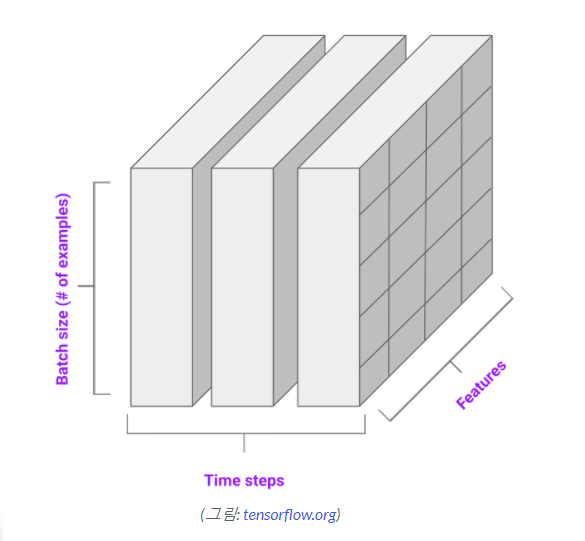

In [34]:
# 텐서플로우 dataset을 이용해 셔플(shuffle)을 수행하되, 배치 크기로 데이터를 묶는다.
# 또한 이 과정에서 teacher forcing을 사용하기 위해 디코더의 입력과 실제값 시퀀스를 구성한다.
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더의 실제값 시퀀스에서는 시작 토큰을 제거해야 한다.
dataset = tf.data.Dataset.from_tensor_slices(( 
    {
        'inputs':questions,
        'dec_inputs': answers[:, :-1] # 디코더의 입력. 마지막 패딩 토큰이 제거됨
    },
    {
        'outputs': answers[:, 1:] # 맨 처음 토큰(시작토큰)이 제거됨. 
    }
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [35]:
# 임의의 샘플에 대해서 [:, :-1]과 [:, 1:]이 어떤 의미를 가지는지 테스트해본다.
print(answers[0]) #기존 샘플
print(answers[:1][:, :-1])  # 마지막 패딩 토큰이 제거되면서 길이가 39가 된다.
print(answers[:1][:, 1:]) # 맨 처음 시작 토큰이 제거되면서 길이가 39가 된다.

[8178 3844   74 7894    1 8179    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
[[8178 3844   74 7894    1 8179    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]]
[[3844   74 7894    1 8179    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]]


## 5. Transformer model 만들기
- 하이퍼파라미터를 조정해 실제 논문의 트랜스포머보다는 작은 모델을 만든다.
- 주요 하이퍼파라미터 값

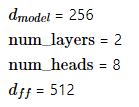

In [36]:
tf.keras.backend.clear_session()

# Hyper-parameters
D_MODEL = 256
NUM_LAYERS = 2
NUM_HEADS = 8
DFF = 512
DROPOUT = 0.1

model = transformer(
    vocab_size = VOCAB_SIZE,
    num_layers = NUM_LAYERS,
    dff = DFF,
    d_model = D_MODEL,
    num_heads = NUM_HEADS,
    dropout = DROPOUT)

(1, 8180, 256)
(1, 8180, 256)


In [37]:
# 학습률, 옵티마이저 정의 & 모델 컴파일
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1 = 0.9, beta_2 = 0.98, epsilon = 1e-9)

def accuracy(y_true, y_pred) :
  #레이블 크기는 (batch_size, MAX_LENGTH -1)
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH -1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [38]:
# 총 50회 모델 학습
EPOCHS = 50
model.fit(dataset, epochs=EPOCHS)

Epoch 1/50
185/185 [==============================] - 17s 54ms/step - loss: 1.4502 - accuracy: 0.0219
Epoch 2/50
185/185 [==============================] - 10s 54ms/step - loss: 1.1802 - accuracy: 0.0492
Epoch 3/50
185/185 [==============================] - 10s 55ms/step - loss: 1.0056 - accuracy: 0.0507
Epoch 4/50
185/185 [==============================] - 10s 55ms/step - loss: 0.9299 - accuracy: 0.0544
Epoch 5/50
185/185 [==============================] - 10s 55ms/step - loss: 0.8717 - accuracy: 0.0576
Epoch 6/50
185/185 [==============================] - 10s 55ms/step - loss: 0.8113 - accuracy: 0.0619
Epoch 7/50
185/185 [==============================] - 10s 54ms/step - loss: 0.7463 - accuracy: 0.0676
Epoch 8/50
185/185 [==============================] - 10s 54ms/step - loss: 0.6748 - accuracy: 0.0753
Epoch 9/50
185/185 [==============================] - 10s 55ms/step - loss: 0.5962 - accuracy: 0.0840
Epoch 10/50
185/185 [==============================] - 10s 54ms/step - loss: 0.514

## 6. 챗봇 평가

In [39]:
def evaluate(sentence):
  sentence = preprocess_sentence(sentence)

  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)
  
  output = tf.expand_dims(START_TOKEN, 0)

  #디코더 예측 시작
  for i in range(MAX_LENGTH):
    predictions = model(inputs=[sentence, output], training=False)

    #현재(마지막) 시점의 예측 단어 받아오기
    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    #만약 마지막 시점의 예측 다어가 종료 토큰이라며 예측을 중단
    if tf.equal(predicted_id, END_TOKEN[0]):
        break

    #마지막 시점의 예측 단어를 출력에 연결한다.
    #이는 for문을 통해서 디코더의 입력으로 사용될 예정이다.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0)

In [40]:
def predict(sentence):
  prediction = evaluate(sentence)

  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])
  
  print('Input: {}'.format(sentence))
  print('Output: {}'.format(predicted_sentence))

  return predicted_sentence

In [41]:
def preprocess_sentence(sentence):
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = sentence.strip()
  return sentence

In [45]:
output = predict("영화 볼래?")

Input: 영화 볼래?
Output: 최신 영화가 좋을 것 같아요 .


In [46]:
output = predict("헤어졌어")

Input: 헤어졌어
Output: 많이 힘들었겠어요 .


In [47]:
output = predict("카페 갈까 말까")

Input: 카페 갈까 말까
Output: 가세요 .


In [55]:
output = predict("오늘 너무 화나")

Input: 오늘 너무 화나
Output: 오늘은 힘내려 하지 말아요 .  저에게 기대세요 .
